In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import (models, transforms)
import os
import utils
from pathlib import Path
import trainer
from torchinfo import summary
import time
import matplotlib.pyplot as plt
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

/home/p3rzival/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [2]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [3]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_default = utils.load_default_model()
pretrained_vit_transforms = pretrained_vit_weights.transforms()

#We freeze all layers since we do not really want to train it again
for parameter in vit_default.parameters():
    parameter.requires_grad = False

loss_fn = nn.CrossEntropyLoss()

/home/p3rzival/TFG-Efficient-Vision-Transformer-Inference-on-Edge-Devices/utils.py:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit.load_state_dict(torch.load(model_pa

In [4]:
import torch
from torchao.quantization.quant_api import quantize_, int8_dynamic_activation_int8_weight
from torchao.utils import unwrap_tensor_subclass, TORCH_VERSION_AT_LEAST_2_5
from torch.utils.benchmark import Timer

vit_quantized = vit_default.to(torch.bfloat16)
_, _, val_dl, _ = utils.create_loaders("data", transform=pretrained_vit_transforms, batch_size=128, dtype=torch.bfloat16)

Files already downloaded and verified


In [5]:
utils.save_model(vit_quantized, "model", "ViT-Quantized-bfloat16.pth")

[INFO] Saving model to: model/ViT-Quantized-bfloat16.pth


In [6]:
#trainer.evaluate(vit_quantized, val_dl, loss_fn, device)

Files already downloaded and verified


 64%|██████▍   | 1275/2000 [09:09<05:11,  2.33it/s]Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/usr/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-i3u38la2'
100%|██████████| 2000/2000 [14:26<00:00,  2.31it/s]


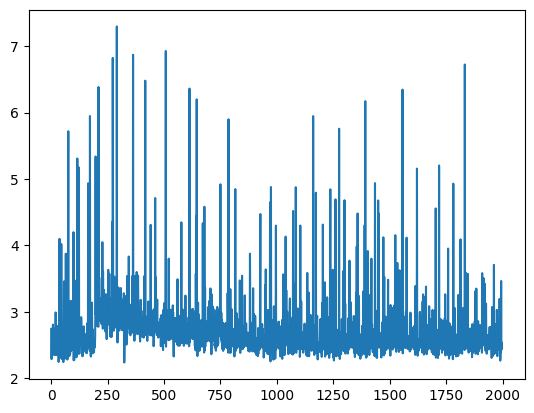

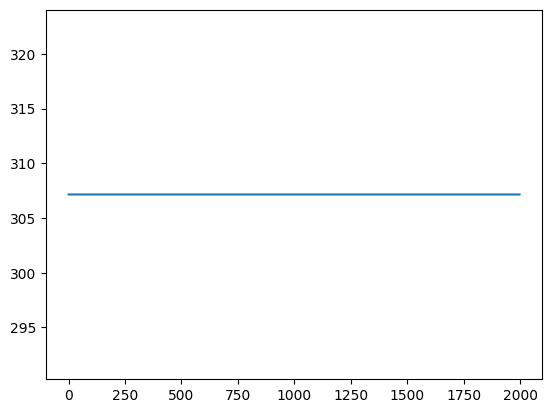

Mean time over 500 executions: 2.73772035019585 ms/batch 
Mean memory over 500 executions: 307.14892578125 MB


In [7]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
_, _, val_dl, _ = utils.create_loaders("data", transform=pretrained_vit_transforms, batch_size=32, dtype=torch.bfloat16)
metrics = trainer.getMetrics(vit_quantized, val_dl, device, num_times=2000)

([<matplotlib.lines.Line2D at 0x79fcc0ed9610>],
 [<matplotlib.lines.Line2D at 0x79fcc0fdc290>])

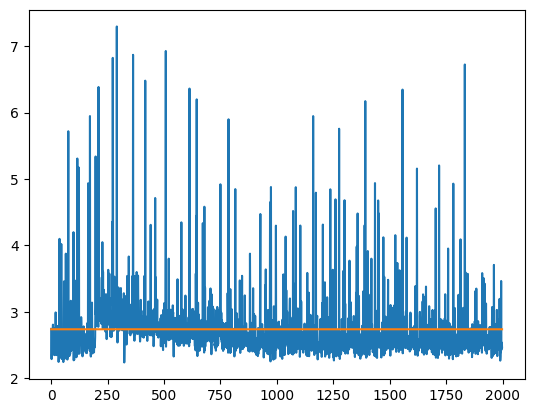

In [9]:
mean = np.repeat(np.mean(metrics["Latency"][1:]), 2000)
plt.plot(metrics["Latency"][1:]),plt.plot(mean[1:])